# PIT for Conditional Flows
Project idea based on [this paper](https://arxiv.org/abs/2102.10473). 

Using the `nflows` library for flow implementations.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import math
import os

import torch.distributions as D
from scipy.stats import multivariate_normal, norm

from nde.train import train
from nde.flows import construct_maf, cdf_flow
from plot import plot_pdf_1D
from diagnostics.pp_plots import (
    cde_pit_values,
    PP_plot_1D,
    PP_vals,
    compare_pp_plots_regression,
    confidence_region_null
)
from diagnostics.localPIT_regression import (
    localPIT_regression_baseline,
    infer_r_alphas_baseline,
    localPIT_regression_grid,
    localPIT_regression_sample,
    infer_r_alphas_amortized, 
)

from data.data_generators import ConditionalGaussian1d
from data.feature_transforms import identity, first_dim_only


## CONTEXT (1D)

Consider the 1D conditional target distribution $f_{\Theta\mid X}$ with **unknown density** and we have **no samples**.

We only have access to samples from the joint distribution $f_{X,\Theta}$: $\quad (\Theta_1,X_1), \dots, (\Theta_n, X_n) \sim f_{X,\Theta}$

Our estimator $f_{Q\mid X}$ is a *Normalizing Flow* whose density is **explicitly known**. It is defined by a base distribution $p_U$ (tipically gaussian) and a bijective transformation $T_{\phi}$: 
$$U\sim p_U \rightarrow Q=T_{\phi}(U, X) \sim f_{Q\mid X}$$ 
$$f_{Q\mid X}(q) = p_{U}\left(T_{\phi}^{-1}(q, X)\right)\left|\operatorname{det} J_{T_{\phi}^{-1}}(q, X)\right|$$ 

Note that we can also define it's c.d.f. explicitly for a fixed $X=x_0$: $\quad F_{Q\mid X=x_0}(q) = \mathbb{P}(Q\leq q \mid X=x_0) =\mathbb{P}(T_{\phi}(U, x_0)\leq q)=\mathbb{P}(U\leq T_{\phi}^{-1}(q, x_0))=F_U(T_{\phi}^{-1}(q, x_0))$

We wish to know evaluate our estimator, with the same method as in the non-conditional case, i.e. with the PIT:

$$\text{PIT}(\theta, x ; f_{Q\mid X}) = \mathbb{P}(Q\leq \theta \mid X=x) = F_{Q \mid X=x}(\theta)$$

## EVALUATION
### True PIT-distribution / Local Consistency
For a fixed $X = x_0$ and $\Theta \sim f_{\Theta \mid X=x_0}$:
$$\begin{aligned} 
f_{Q\mid x_0} = f_{\Theta\mid x_0} & \iff \text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \sim \mathcal{U}(0,1)\\
& \iff \mathbb{P}_{\Theta \mid x_0}(\text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \leq \alpha) = \alpha, \quad \forall \alpha \in [0,1]\\
& \iff F_{\Theta \mid X=x_0}(F_{Q \mid X=x_0}^{-1}(\alpha)) = \alpha, \quad \forall \alpha \in [0,1]
\end{aligned}$$

We find ourselves with the same result as in the non-conditional 1D case , as $X$ is fixed at $x_0$ (cf. Theorem 2 in paper). 

**Problem:** We are unable to compute the c.d.f. of the target distribution $F_{\Theta \mid X=x_0}$, as the density $f_{\Theta \mid x_0}$ is unknown and no samples $\theta_i \mid x_0$ are available to approximate it empirically.

### Expected PIT-distribution over $X$ / Global Consistency 
We can however compute the empirical **expected c.d.f. over $X$** by using the samples from the joint distribution. 

$$\begin{aligned}
\mathbb{E}_X[F_{\Theta\mid X}(F_{Q\mid X}(\alpha)^{-1})] & = \mathbb{E}_X[\mathbb{P}_{\Theta\mid X}(F_{Q\mid X}(\Theta)\leq \alpha)]\\
& = \mathbb{E}_X[\mathbb{E}_{\Theta\mid X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]]\\
& = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]\\
& \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}
\end{aligned}$$

This gives us an approximation of the **expected (or joint) PIT-distribution:** 

$$\mathbb{E}_X[\mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha)] = \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}] \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}$$

#### Result 1: 
It is still true that if $\forall X, f_{Q\mid X} = f_{\Theta\mid X} $ (global consistency) and $\Theta, X \sim f_{\Theta, X}$, the *joint PIT-distribution* is uniform:

$$f_{Q\mid X} = f_{\Theta\mid X} \Rightarrow \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) =\alpha, \quad \forall \alpha \in [0,1]$$

**Problem:** The reverse is not true! This quantity does not allow us to evaluate our estimator (i.e. check global concistency) in a reliable way: we can find globally non-consistent estimators ($f_{Q\mid X} \neq f_{\Theta\mid X}$), but whose joint PIT-distribution is uniform. 

#### Result 2: 
Uniformity of the expected PIT-distribution holds for any estimator $f_{Q\mid X} = f_{\Theta\mid g(X)}$ with $g$ a given function (cf. Theorem 1 in paper).

#### Proofs can be found [here](https://notes.inria.fr/s/rhHwKKzaK).

### Global vs. Local Consistency: Illustration via Code 

Let's look at some code to illustrate this.

We consider a target density $\Theta\mid X \sim \mathcal{N}(X_1+X_2, 1)$ with $X = (X_1, X_2) \sim \mathcal{N}(\mu, \Sigma)$ where $\mu = [\mu_1, \mu_2]$ and $\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.



In [2]:
# GLOBAL PARAMETER
ALPHAS = np.linspace(0, 0.999, 100)

#### DATA Generation of Toy-model


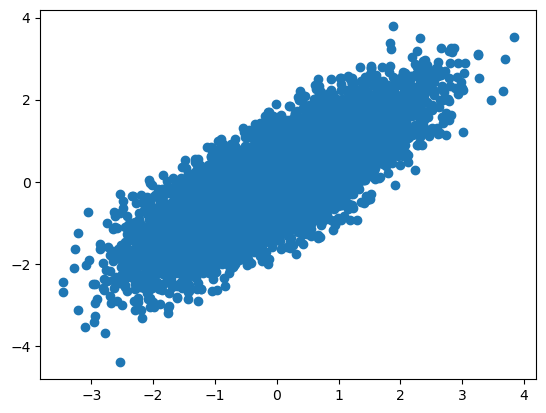

In [3]:
# nb samples (same as in code from paper)
n = 10_500
# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d()
# Samples from the joint distribution P(Theta,X) = P(X)*P(Theta|X)
samples_x, samples_theta = data_gen.get_joint_data(n=n)


# plot X-distribution
plt.scatter(samples_x[:, 0], samples_x[:, 1])
plt.show()


#### Result 1: Uniformity of the expected PIT-distribution

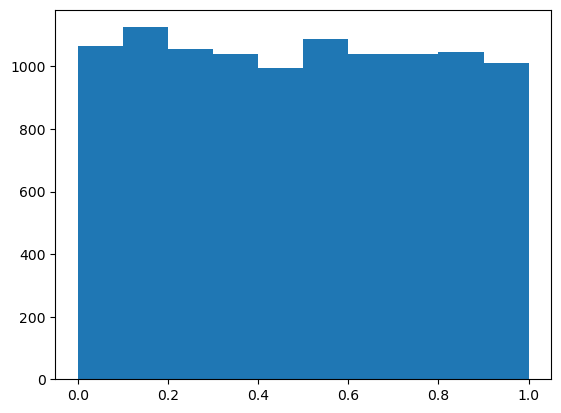

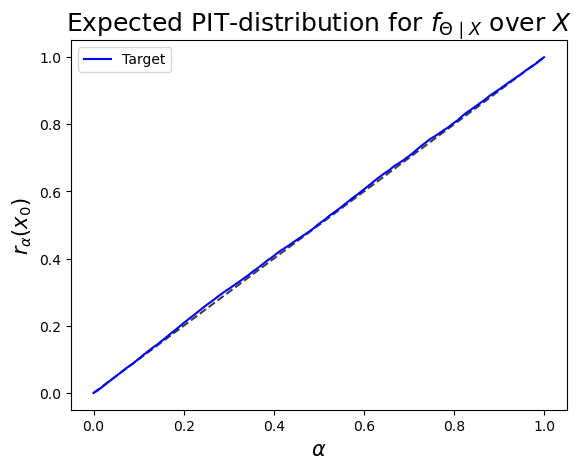

In [4]:
# PLOT EXPECTED PIT-DISTRIBUTION for the true distribution Theta|X

# Joint PIT-values [PIT(Theta_i, X_i, f_{Theta|X})]
true_joint_pit_values = data_gen.true_pit_values(samples_theta, samples_x)

# Plot histogram of expected PIT-distribution
plt.hist(true_joint_pit_values)
plt.show()

# PP-plot of expected PIT-distribution
PP_plot_1D(
    PIT_values=[true_joint_pit_values],
    alphas=ALPHAS,
    title=r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$",
)


#### Result 2: Uniformity of globally non-consistent estimators
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

In [5]:
# Get train, val and test samples:
# - train samples are used to train the flow,
# - test samples are used to compute/learn the PIT-distribution

# Split in train/test sets (same as in code from paper)
train_size = 10_000  # test_size = 500
x_train, x_test = samples_x[:train_size], samples_x[train_size:]
theta_train, theta_test = samples_theta[:train_size], samples_theta[train_size:]

print("NB training samples: ", x_train.shape)
print("NB test samples: ", x_test.shape)


NB training samples:  torch.Size([10000, 2])
NB test samples:  torch.Size([500, 2])


In [6]:
# TRAIN FLOWS

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=True, num_layers=10
)

# ... trained on X=(X_1,X_2)
filename = 'saved_experiments/Gaussian1d_localPIT/maf_good_layers10.pkl'
if os.path.exists(filename):
    maf_good = torch.load(filename)
else:
    _, _ = train(
        maf_good,
        theta_train,
        context=x_train,  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

# Bad MAF...
maf_bad = construct_maf(
    theta_train, hidden_features=50, context_features=1, standardize_transform=True, num_layers=10
)

# trained on g(X)=(X_1)
g = first_dim_only
filename = 'saved_experiments/Gaussian1d_localPIT/maf_bad_layers10.pkl'
if os.path.exists(filename):
    maf_bad = torch.load(filename)
else:
    _, _ = train(
        maf_bad,
        theta_train,
        context=g(x_train),  # g(X)=(X_1)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

torch.save(maf_good, 'saved_experiments/Gaussian1d_localPIT/maf_good_layers10.pkl')
torch.save(maf_bad, 'saved_experiments/Gaussian1d_localPIT/maf_bad_layers10.pkl')

##### Global Consistency

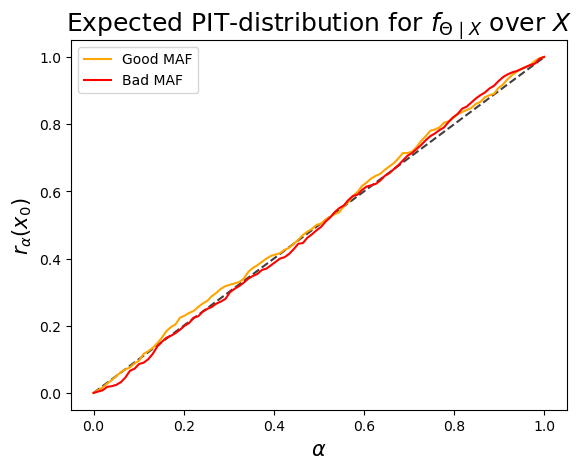

In [7]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = cde_pit_values(
    theta_test, x_test, maf_good, feature_transform=identity
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = cde_pit_values(

    theta_test, x_test, maf_bad, feature_transform=first_dim_only
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good, flow_joint_pit_values_bad],
    alphas=ALPHAS,
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$",
    confidence_int=False,
)


Both estimators have uniform PIT-distribution, but the bad MAF is not globally consistent. 

Indeed, the code below will show that the bad MAF is locally inconsistent, which implies also that it cannot be globally consistent.

##### Local Consistency

/Users/julialinhart/Documents/Code/github/valDiags_flows/plot.py:12: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  eval_x = torch.linspace(x_i, x_f).reshape(-1, 1)


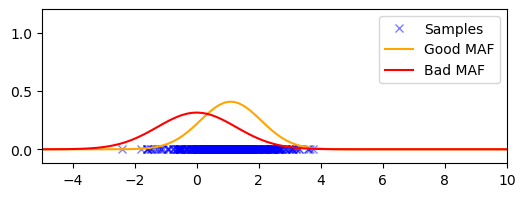

In [8]:
# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_test))]
).reshape(-1, 1)

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good, x_0, "orange"), "Bad MAF": (maf_bad, x_0[:, 0], "red")}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)


We can already see that the two flows disagree. Espcially in the variance. 

This was not represented in the global pp-plot, but can be visualized via the local pp-plot (see code below).

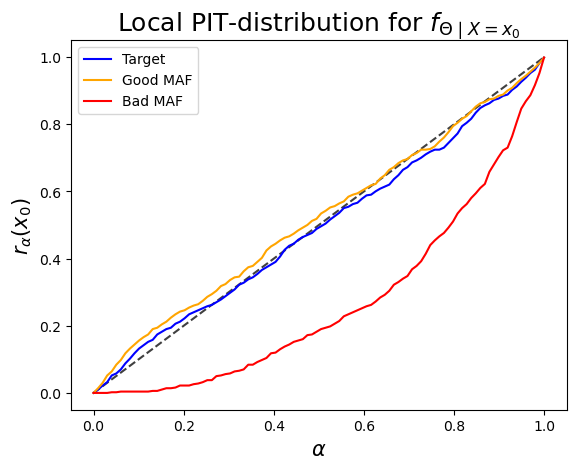

In [9]:
# Local PIT-distribution on samples Theta_i from Theta|X=x_0

# Compute PIT-values [PIT(Theta_i, X=x_0, f_true/good/bad) = F_{Q|X_i}(Theta_i)]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x, x_0, local=True)
flow_local_pit_values_good = cde_pit_values(
    samples_theta_x, x_0, flow=maf_good, feature_transform=identity, local=True
)
flow_local_pit_values_bad = cde_pit_values(
    samples_theta_x, x_0, flow=maf_bad, feature_transform=first_dim_only, local=True
)

# PP-plot of the local distribution
# alpha-quantiles = [P_{Theta|X}(Z < alpha)]
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=ALPHAS,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution for $f_{\Theta \mid X=x_0}$",
    confidence_int=False,
)


Indeed, the variance distorsion of the bad MAF is clearly visible in this pp-plot (red line in S-shape). 

This shows that if our function $g(X)$ doas not caracterize covariate relations between the elements of $X$ (e.g. non-sufficient summary statistics), the expected PIT-distribution will not show us the error, whereas the local PIT-distribution does.

We need a way to claculate the local PIT-distribution! 

## Estimating the Local PIT-Distribution

We define the $\alpha$-quantile of the local PIT-distribution as follows:

$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}\mid X]$$

### Method 1 proposed by [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473): 
**Regression of $W^{\alpha} = \mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}$ on $X$, using samples from the joint $(\Theta_i, X_i) \sim f_{\Theta, X}$.**

The goal is to estimate the random variable $W^{\alpha}$ as a function $f$ of $X$. 

Theoretically, the optimal solution of this regression problem - in terms of $L^2$-distance $E\left[(W^{\alpha} - f(X))^2\right]$ - is the conditional expectation $f^{\star}(X) = \mathbb{E}[W^{\alpha} \mid X] = r_{\alpha}(X)$ (it corresponds to the othogonal projection of $W^{\alpha}$ on $L^2(\Omega, \mathcal{F}(X), \mathbb{P}) = L^2_X$).

#### Algorithm:
1. pre-compute $W^{\alpha}_i$ using the avalable samples $\Theta_i, X_i$
2. regress $W^{\alpha}_i$ on $X_i$ to get an estimate of $r_{\alpha}(X)$
3. evaluate $r_{\alpha}$ in $X=x_0$
4. plot $r_{\alpha}(x_0)$ as a function of $\alpha$ and compare to identity

#### Comments
- This is actually a binary classifiacation problem 
- We need to use a regressor / classifier that has an optimum defined by the conditional expectation! Different loss function (i.e. classifiers) can be used (cf. [On Loss Functions Which Minimii to Conditional Expected Values and Posterior Probabilities](https://authors.library.caltech.edu/93850/1/00243457.pdf)). Here they use `sklearn.MLPClassifier` trained with a log-loss (compatible).
- There is a monotonic coupling / ordering between $r_{\alpha}(X)$ and $\alpha$: $r_{\alpha}(X) \nearrow \alpha$
    - cf. [isotonic regression with monotonic constraint in sklearn](https://scikit-learn.org/stable/modules/isotonic.html) (//calibration with binary target variable)
    - what about the multivariate case? cf. Random Forest for multi-output with monotonic splitting criteria?
    - implement existing method and analyse if monotonic or not in $\alpha$


#### Implementation of the Regression Method from [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473):

In [10]:
# Training set for regression task: Samples from the joint !
# test set used for empirical approximations earlier
theta_train_PIT = theta_test
x_train_PIT = x_test

# PIT-values [PIT(Theta_i, X_i, flow)] used to compute labels 
pit_values_train_good = flow_joint_pit_values_good.ravel()
pit_values_train_bad = flow_joint_pit_values_bad.ravel()

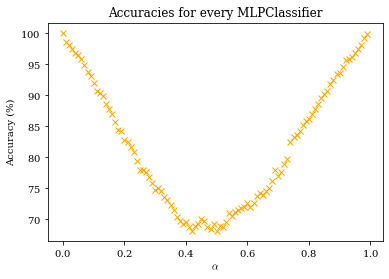

Mean training accuracy:  81.83


In [13]:
# Estimate local PIT-distribution quantiles for bad MAF
# Train several classifiers for each alpha value 
alphas = np.linspace(0,0.99,100)
pit_values_train = pit_values_train_bad
clfs = localPIT_regression_baseline(
    alphas=alphas, 
    pit_values_train=pit_values_train, # pit-values used to compute the targets
    x_train=x_train_PIT,
)
accuracies = {}
for alpha in alphas:
    W_a_train = (pit_values_train <= alpha).astype(int)  # compute the targets
    accuracies[alpha] = clfs[alpha].score(x_train_PIT, W_a_train) * 100

# Plot accuracies as a function of alpha
accuracies = pd.Series(accuracies)
accuracies.plot(style="x", color="orange")
plt.title(r"Accuracies for every MLPClassifier")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy (%)")
plt.show()
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))

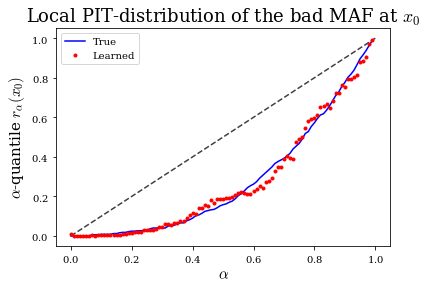

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.281
Mean training accuracy:  81.83
Monotonicity: 72.73% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


In [14]:
# Local PP-plot

# estimate local pit values at x_0 for every alpha
r_alpha_test = infer_r_alphas_baseline(x_0, clfs)
r_alpha_test = pd.Series(r_alpha_test)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=np.linspace(0,0.99,100),
    r_alpha_learned = [r_alpha_test],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, np.array(r_alpha_test))
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(np.array(r_alpha_test)) >= 0)
print(
    f"Monotonicity: {np.round(monotonicity*100,2)}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)


Errors:
- logisticregressor doesnt work because needs 2 classes in training data. 
- Isotonic regression doesn't work because 'input X should be a 1d array or 2d array with 1 feature'. Anyway it should be increasing with alpha and not x.
- if including 1 in the alphas list, we get an outlier in the prediction

Comments:
- MLP trained for classification with the `log_loss`: $L_{\log }(y, p)=-(y \log (p)+(1-y) \log (1-p))$
- $p=$`predict_proba[:,1]` gives the probability of the **class $1$**, the success class of being $\leq \alpha$
- The classifiers are less accurate in the middle range, which is exactly what we expect: 
    - the goal is to plot the miscalibration of the probabilities, so it is normal that the accuracies drop for a miscalibrated problem: **Accuracy is not the right metric here!** 
    - cf. comparison to `Dummy` whose accuracy drops to $0.5$ at $\alpha = 0.5$ (linear function)


### Amortized in alpha 

**Idea: Only one Classifier on alpha and X:**
- can make relationship between r_alpha and alpha explicit and thus learn the monotonic constraint? 
- converges to what theoretically?

#### Method 2: 
Expand the training-set to take into account all ${\alpha_t}$ $\in$ `np.linspace(0,1,T)`:
- new targets: $W^{\alpha_t}_i$ for all $\alpha_t$ and $(\Theta_i, X_i)$
- new features **including $\alpha$**: $\{(X_0,\alpha_t), \dots, (X_n,\alpha_t)\}$ for all $\alpha_t$

The size is multiplied by the number $T$ of $\alpha$-values (here $T=101$)


In [16]:
# Estimate the local PIT
# Train the Classifier amortized on x and all alphas
clf_grid = localPIT_regression_grid(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
)


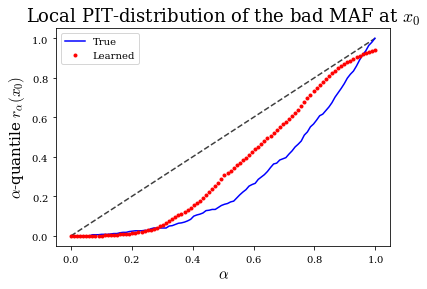

Euclidean Distance to empirical local pit-distribution (ground-truth):  1.082
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


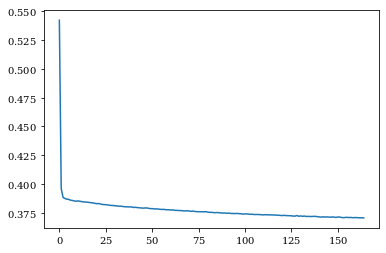

In [18]:
# Local PP-Plot

# Evaluate in x_0 and for all alphas
r_alpha_test_grid = infer_r_alphas_amortized(x_0, ALPHAS, clf_grid)
r_alpha_test_grid = pd.Series(r_alpha_test_grid)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned=[r_alpha_test_grid],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_grid)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_grid) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(clf_grid.loss_curve_)
plt.show()

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_hist = HistGradientBoostingClassifier(monotonic_cst=[0, 0, 1], max_iter=70)


clf_grid_hist = localPIT_regression_grid(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    classifier=clf_hist
)

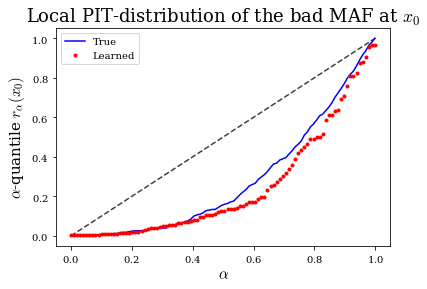

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.493
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


In [22]:
# Local PP-Plot
r_alpha_test_hist_grid = infer_r_alphas_amortized(x_0, ALPHAS, clf_grid_hist)
r_alpha_test_hist_grid = pd.Series(r_alpha_test_hist_grid)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned=[r_alpha_test_hist_grid],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_hist_grid)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_hist_grid) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

#### Method 3:
Sample $\alpha \sim \mathcal{U}(0,1) $ $T=1$ time for each sample $(\Theta_i, X_i)$ of the joint. 

In [23]:
# Train the Classifier amortized on x and 1 sampled alpha

clf_sample = localPIT_regression_sample(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    nb_samples=1,
)



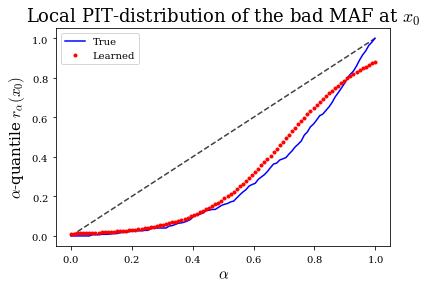

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.493
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


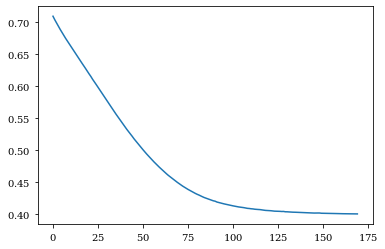

In [24]:
# Local PP-Plot

# Evaluate in x_0 and for all alphas
r_alpha_test_sample = infer_r_alphas_amortized(x_0, ALPHAS, clf_sample)
r_alpha_test_sample = pd.Series(r_alpha_test_sample)
PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned = [r_alpha_test_sample],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_sample)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_sample) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(clf_sample.loss_curve_)
plt.show()


**Comments:**

- The original method needs multiple classifiers (one for each alpha value) is not verifying the monotonic constraint. 
- The in alpha amortized versions insure that the monotonic constrain is respected. BUT depending on the $x_0$ used for evaluation, the amortized versions can be pretty far from the black groundtruth (euclidean distance). 
- We could increase $T$ for method 3 (e.g. $T=20$).
- Accuracy is not the right metric! 
- We should compare the results in one plot: distance to GT (black curve), computational time, number of training samples needed (alpha samples during training and features...)

**TODO:**
- Evaluate the variance of the methods over several trainings of a model evaluated in the same $x_0$ (model uncertainty)
- Evaluate the variance of the methods over several choices of $x_0$ (data uncertainty)
- Plots to visualize comparisons between methods:
    - distance to ground-truth
    - computational cost
    - number of training samples needed
    
Small checks:
- Compare to `LogisticRegression`
- See convergence criteria of `MLPClassifier`
- confidence intervals like in paper code? 
- add constraint (bounds (0,1)?)
- regularize?




In [26]:
# Train the Classifier amortized on x and multiple sampled alpha

clf_sample_T = localPIT_regression_sample(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    nb_samples=50,
)


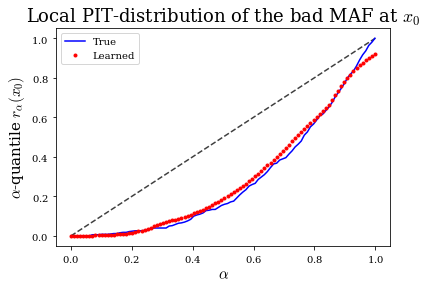

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.269
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


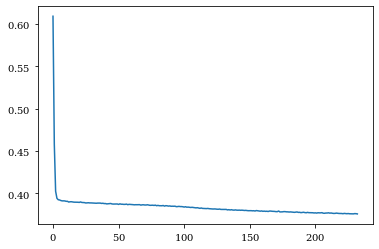

In [27]:
# Local PP-Plot
# Evaluate in x_0 and for all alphas
r_alpha_test_sample_T = infer_r_alphas_amortized(x_0, ALPHAS, clf_sample_T)
r_alpha_test_sample_T = pd.Series(r_alpha_test_sample_T)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned = [r_alpha_test_sample_T],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_sample_T)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_sample_T) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(clf_sample_T.loss_curve_)
plt.show()


### Compare Local PIT Regression Methods

In [14]:
from diagnostics.uni_local_test_scripts import run_localPIT_regression

#### Show that for grid and sample methods 500 samples are not enough 


In [14]:
# 500 samples

from functools import partial
mlp_sample_1 = partial(localPIT_regression_sample, nb_samples=1)
mlp_sample_50 = partial(localPIT_regression_sample, nb_samples=50)

methods = [
    localPIT_regression_baseline,
    localPIT_regression_grid,
    mlp_sample_1,
    mlp_sample_50
]

method_names = ['baseline', 'grid', 'sample 1', 'sample 50']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
    samples_train=(x_train_PIT, theta_train_PIT)
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid
sample 1
sample 50
x_eval 1:  tensor([[0., 1.]])
baseline
grid
sample 1
sample 50
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid
sample 1
sample 50
NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid
sample 1
sample 50
x_eval 1:  tensor([[0., 1.]])
baseline
grid
sample 1
sample 50
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid
sample 1
sample 50


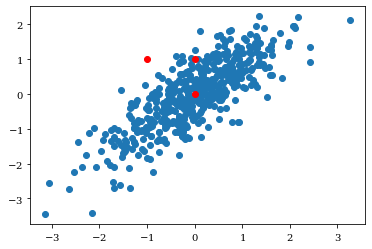

In [15]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

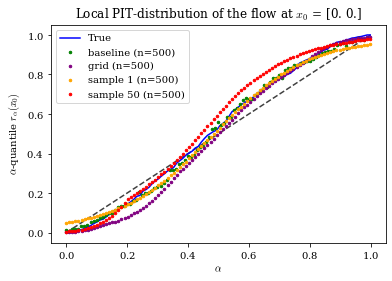

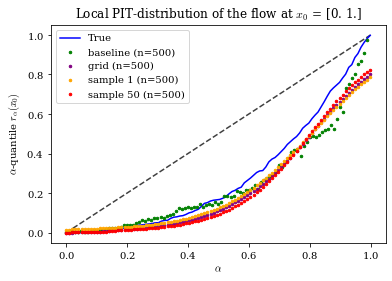

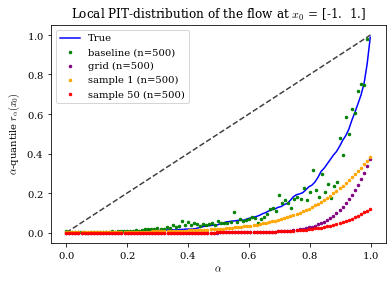

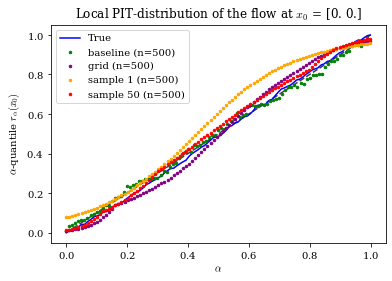

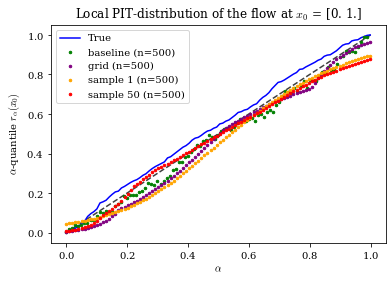

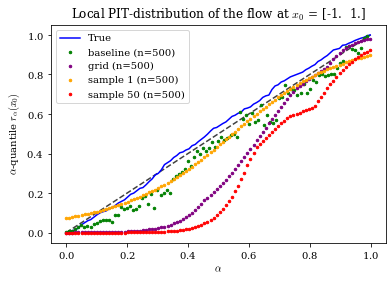

In [16]:
# show that for grid and sample methods 500 samples are not enough 

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

#### Show that x_eval needs to be in training data distribution

In [22]:
# 5000 samples

from functools import partial
mlp_sample_1 = partial(localPIT_regression_sample, nb_samples=1)
mlp_sample_50 = partial(localPIT_regression_sample, nb_samples=50)

methods = [
    localPIT_regression_baseline,
    localPIT_regression_grid,
    mlp_sample_1,
    mlp_sample_50
]

method_names = ['baseline', 'grid', 'sample 1', 'sample 50']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

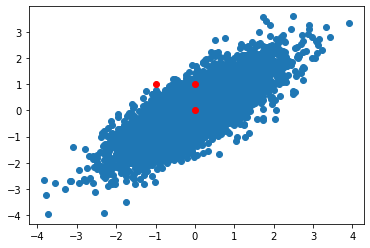

In [23]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

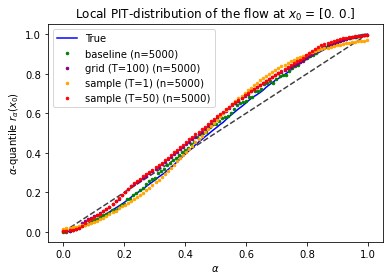

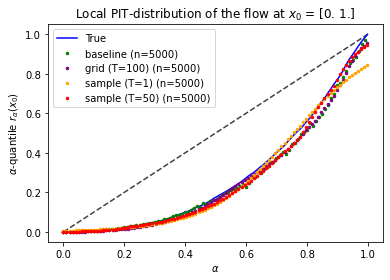

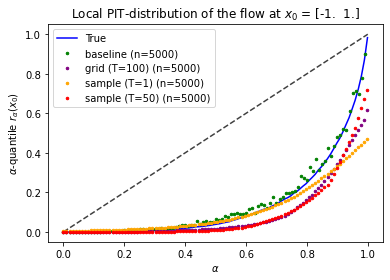

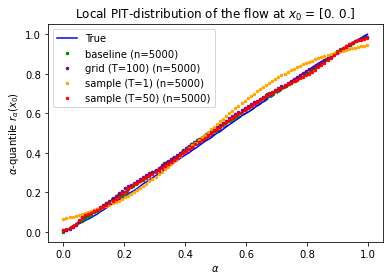

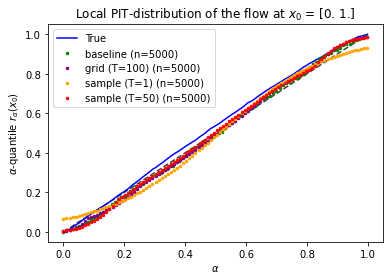

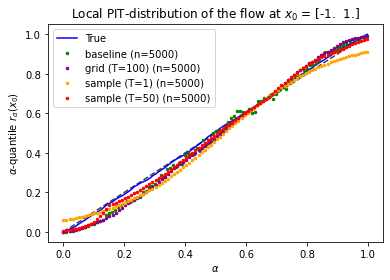

In [25]:
# show that x_eval needs to be in training data distribution

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

500 samples were not enough for the 'amortized in alpha'-methods
- more to learn
- not enough x samples for the amount of alphas used
- x_eval has to be in the distribution of the train set, no generalisation outside of this range.
- the baseline can concentrate on learning point-estimates for a given alpha and lots of x samples --> better generalization w.r.t. x 

I tried for 5000 samples to train the classifiers.
- all methods work 
- grid-method does not work if x_eval is not in the distribution of the train set. 
- Overfit of grid-method, no generalisation outside of this range.

**PROBLEM:** to estimate the local PIT-distribution we need a ML algorithm that also requires summry statistics on X.

## Improving the Regressor using `HistGradientBoostingClassifier` with monotonic constraint on only the `alpha` variable

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier
from functools import partial

clf = HistGradientBoostingClassifier(monotonic_cst=[0, 0, 1], max_iter=70)

hist_reg_grid = partial(localPIT_regression_grid, classifier=clf)
hist_reg_sample_1 = partial(localPIT_regression_sample, classifier=clf, nb_samples=1)
hist_reg_sample_50 = partial(localPIT_regression_sample, classifier=clf, nb_samples=50)


In [18]:
# 500 samples

methods = [
    localPIT_regression_baseline,
    hist_reg_grid,
    hist_reg_sample_1,
    hist_reg_sample_50
]

method_names = ['baseline', 'grid_hist', 'sample_1_hist', 'sample_50_hist']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
    samples_train=(x_train_PIT, theta_train_PIT)
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
    )
    

NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist


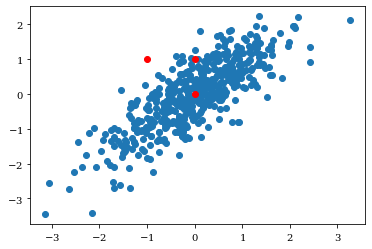

In [19]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

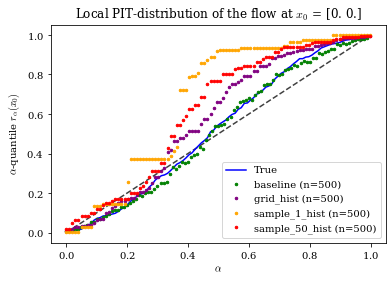

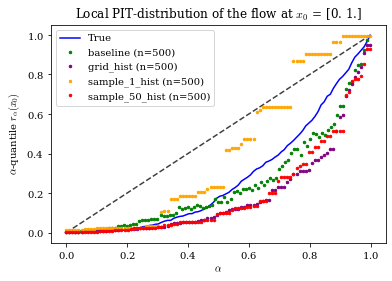

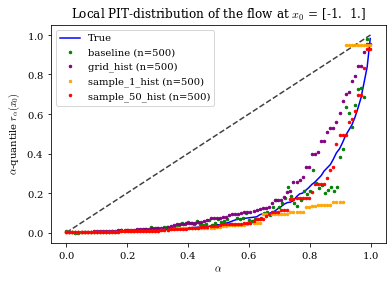

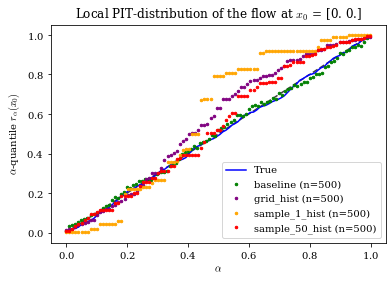

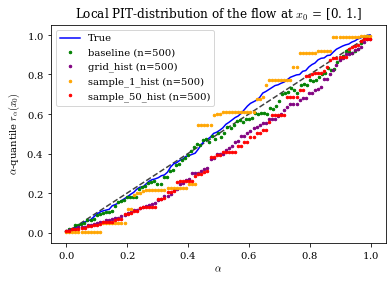

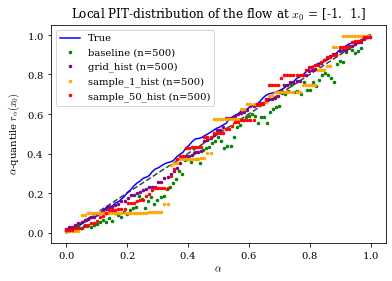

In [20]:
# show that for grid and sample methods 500 samples are not enough 

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

#### Show that x_eval needs to be in training data distribution

In [22]:
# 5000 samples

methods = [
    localPIT_regression_baseline,
    hist_reg_grid,
    hist_reg_sample_1,
    hist_reg_sample_50
]

method_names = ['baseline', 'grid_hist', 'sample_1_hist', 'sample_50_hist']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist


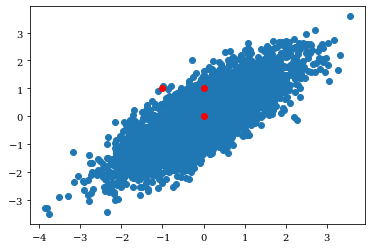

In [23]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

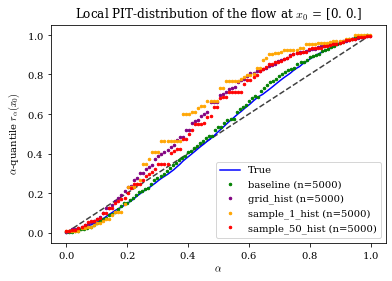

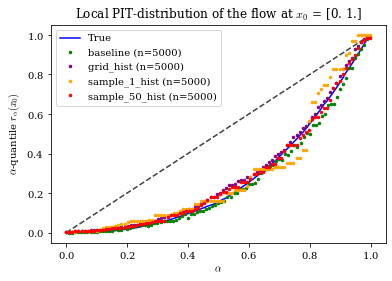

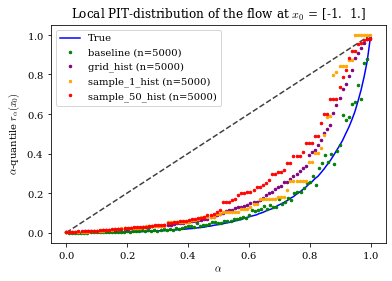

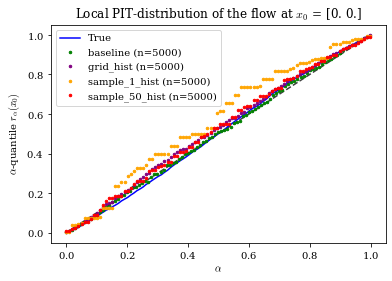

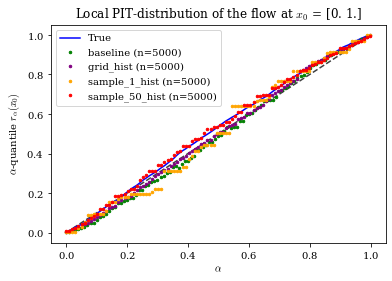

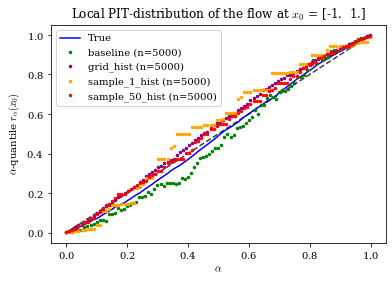

In [24]:
# show that x_eval needs to be in training data distribution

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

## Emprircal method comparison

In [11]:
from diagnostics.uni_local_test_scripts import run_localPIT_regression
from sklearn.ensemble import HistGradientBoostingClassifier
from functools import partial

clf = HistGradientBoostingClassifier(monotonic_cst=[0, 0, 1], max_iter=70)

hist_reg_grid = partial(localPIT_regression_grid, classifier=clf)
hist_reg_sample_1 = partial(localPIT_regression_sample, classifier=clf, nb_samples=1)
hist_reg_sample_50 = partial(localPIT_regression_sample, classifier=clf, nb_samples=50)

sample_1_mlp = partial(localPIT_regression_sample, classifier=clf, nb_samples=1)
sample_50_mlp = partial(localPIT_regression_sample, classifier=clf, nb_samples=50)

methods = [
    localPIT_regression_baseline,
    localPIT_regression_grid,
    sample_1_mlp,
    sample_50_mlp,
    hist_reg_grid,
    hist_reg_sample_1,
    hist_reg_sample_50,
]

method_names = [
    'baseline',
    'grid_mlp',
    'sample_1_mlp',
    'sample_50_mlp',
    'grid_hist',
    'sample_1_hist',
    'sample_50_hist',
]



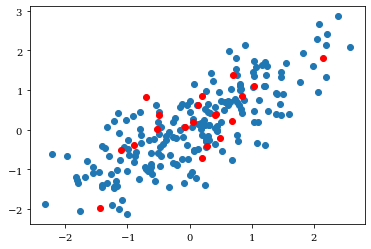

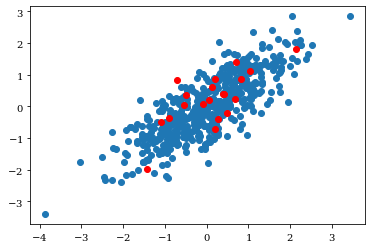

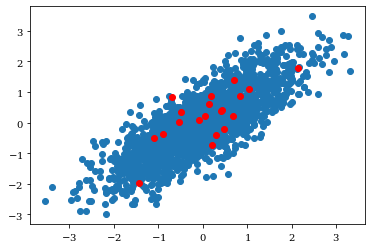

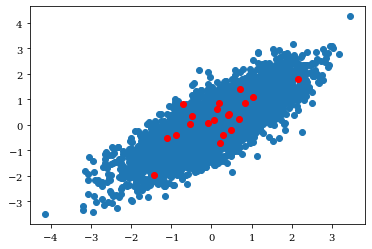

In [12]:
filename_eval = 'saved_experiments/Gaussian1d_localPIT/eval_samples.pkl'
filename_train = 'saved_experiments/Gaussian1d_localPIT/train_samples.pkl'

if os.path.exists(filename_eval):
    x_evals = torch.load(filename_eval)
else:
    x_evals,_ = data_gen.get_joint_data(20)
    torch.save(x_evals, 'saved_experiments/Gaussian1d_localPIT/eval_samples.pkl')


nb_samples = [200, 500, 2000, 5000]
if os.path.exists(filename_train):
    samples_train = torch.load(filename_train)
else:
    nb_samples = [200, 500, 2000, 5000]
    samples_train = []
    for n_train in nb_samples:
        samples_train.append(data_gen.get_joint_data(n_train))
    torch.save(samples_train, 'saved_experiments/Gaussian1d_localPIT/train_samples.pkl')

for i, n_train in enumerate(nb_samples):
    x_train_samples = samples_train[i][0]
    plt.scatter(x_train_samples[:,0], x_train_samples[:,1])
    plt.scatter(list(x_evals[:,0]), list(x_evals[:,1]), color='red')
    plt.show()


In [13]:
# estimate local PIT values 

filename_ralphas_badmaf = 'saved_experiments/Gaussian1d_localPIT/r_alphas_badmaf_new.pkl'
if os.path.exists(filename_ralphas_badmaf):
    dict_r_alphas = torch.load(filename_ralphas_badmaf)
    dict_true_pit_values = torch.load('saved_experiments/Gaussian1d_localPIT/true_pit_values_badmaf_new.pkl')
else:
    dict_r_alphas = {}
    dict_true_pit_values = {}
    for i in range(len(nb_samples)):
        r_alpha_learned, labels, true_pit_values, _, _ = run_localPIT_regression(
            methods,
            method_names,
            x_evals.reshape(len(x_evals),1,2),
            nb_train_samples=nb_samples[i],
            joint_data_generator=data_gen.get_joint_data,
            flow=maf_bad,
            feature_transform=first_dim_only,
            samples_train= samples_train[i],
        )
        dict_true_pit_values[str(nb_samples[i])] = true_pit_values
        dict_r_alphas[str(nb_samples[i])] = r_alpha_learned
    torch.save(dict_r_alphas, 'saved_experiments/Gaussian1d_localPIT/r_alphas_badmaf_new.pkl')
    torch.save(dict_true_pit_values, 'saved_experiments/Gaussian1d_localPIT/true_pit_values_badmaf_new.pkl')

NULL HYP:  False
x_eval 0:  tensor([[0.8360, 0.8528]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[-0.5283,  0.0248]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[0.0537, 0.1987]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x_eval 3:  tensor([[-0.0770,  0.0701]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x_eval 4:  tensor([[1.0306, 1.1030]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x_eval 5:  tensor([[0.4262, 0.4027]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x_eval 6:  tensor([[0.6830, 0.2142]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x_eval 7:  tensor([[-1.4355, -1.9724]])
baseline
grid_mlp
sample_1_mlp
sample_50_mlp
grid_hist
sample_1_hist
sample_50_hist
x

In [ ]:
# EUCLIDEAN DISTANCE TO GT PP-PLOT FUNCTION

dict_euc_dist_to_gt = {}
for k in nb_samples:
    r_alpha_learned = dict_r_alphas[str(k)]
    euc_dist_to_gt = {}
    for i in range(len(x_evals)):
        for method_name, r_alpha in zip(method_names, r_alpha_learned[i]):
            if i == 0:
                euc_dist_to_gt[method_name] = {}
            true_pit_values = dict_true_pit_values[str(k)][i]
            # Evaluation metrics
            alphas = list(r_alpha.keys())
            true_pp_vals = PP_vals(true_pit_values, alphas)
            euc_dist_to_gt[method_name][i] = math.dist(true_pp_vals, list(r_alpha.values()))
    dict_euc_dist_to_gt[str(k)] = euc_dist_to_gt



In [ ]:
dict_mean_euc_dist = {}
dict_var_euc_dist = {}
for k in nb_samples:
    dict_mean_euc_dist[str(k)] = {}
    dict_var_euc_dist[str(k)] = {}
    for method_name in method_names:
        dict_mean_euc_dist[str(k)][method_name] = np.mean(list(dict_euc_dist_to_gt[str(k)][method_name].values()))
        dict_var_euc_dist[str(k)][method_name] = np.std(list(dict_euc_dist_to_gt[str(k)][method_name].values()))


- plots: pp-plots, dist as function of samples 
- p-values 
- time


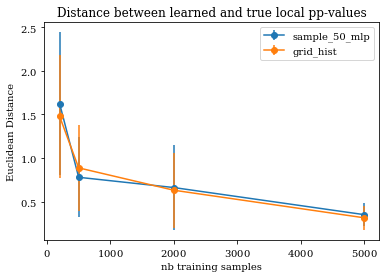

In [30]:
for method_name in method_names:
    # if not ('1' in method_name or 'baseline' in method_name or 'grid_mlp' in method_name):
    if method_name in ['sample_50_mlp', 'grid_hist']:  
        mean_euc_dist_list = [dict_mean_euc_dist[str(ns)][method_name] for ns in nb_samples]
        var_euc_dist_list = [dict_var_euc_dist[str(ns)][method_name] for ns in nb_samples]
        plt.errorbar(nb_samples, mean_euc_dist_list, yerr=var_euc_dist_list, label=method_name, marker='o')
plt.xlabel('nb training samples')
plt.ylabel('Euclidean Distance')
plt.title('Distance between learned and true local pp-values')
plt.legend()
plt.show()

In [31]:
# time to estimate local PIT values 

filename_time = 'saved_experiments/Gaussian1d_localPIT/times.pkl'
if os.path.exists(filename_time):
    dict_time = torch.load(filename_time)
else:
    dict_time = {}
    for i in range(len(nb_samples)):
        _, _, _, _ , times = run_localPIT_regression(
            methods,
            method_names,
            x_evals[:1].reshape(len(x_evals[:1]),1,2),
            nb_train_samples=nb_samples[i],
            joint_data_generator=data_gen.get_joint_data,
            flow=maf_bad,
            feature_transform=first_dim_only,
            samples_train= samples_train[i],
        )
        dict_time[str(nb_samples[i])] = times
        
    torch.save(dict_time, 'saved_experiments/Gaussian1d_localPIT/times.pkl')

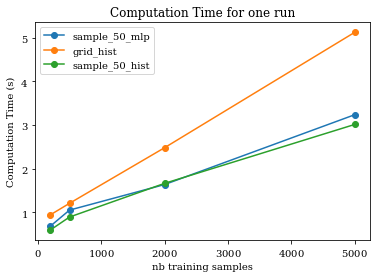

In [33]:
for i,method_name in enumerate(method_names):
    if method_name in ['sample_50_mlp', 'sample_50_hist', 'grid_hist']:
        time_dist_list = [dict_time[str(ns)][i]*-1 for ns in nb_samples]
        plt.plot(nb_samples, time_dist_list, label=method_name, marker='o')
plt.xlabel('nb training samples')
plt.ylabel('Computation Time (s)')
plt.title('Computation Time for one run')
plt.legend()
plt.show()

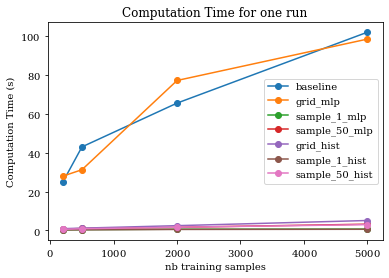

In [34]:
for i,method_name in enumerate(method_names):
    time_dist_list = [dict_time[str(ns)][i]*-1 for ns in nb_samples]
    plt.plot(nb_samples, time_dist_list, label=method_name, marker='o')
plt.xlabel('nb training samples')
plt.ylabel('Computation Time (s)')
plt.title('Computation Time for one run')
plt.legend()
plt.show()

In [ ]:
from diagnostics.uni_local_test_scripts import compute_pvalues

methods = [
    localPIT_regression_baseline,
    sample_50_mlp,
    hist_reg_grid,
    hist_reg_sample_50,
]

method_names = [
    'baseline',
    'sample_50_mlp',
    'grid_hist',
    'sample_50_hist',
]

# nb_samples = [200,500,2000, 5000]
nb_samples = [500]
for i in range(len(nb_samples)):
    r_alpha_pit_dict, r_alpha_null_dict, pvalues = compute_pvalues(
        methods,
        method_names,
        x_0.reshape(1,1,2),
        nb_train_samples=nb_samples[i],
        joint_data_generator=data_gen.get_joint_data,
        flow=maf_bad,
        feature_transform=first_dim_only,
        samples_train= samples_train[i+1],
        n_trials = 100,
    )
    torch.save(pvalues, f'saved_experiments/Gaussian1d_localPIT/pvalues_100t_{nb_samples[i]}s.pkl')


In [ ]:
pvalues

In [ ]:
methods = [
    localPIT_regression_baseline,
    sample_50_mlp,
    hist_reg_grid,
    hist_reg_sample_50,
]

method_names = [
    'baseline',
    'sample_50_mlp',
    'grid_hist',
    'sample_50_hist',
]

# nb_samples = [200,500,2000, 5000]
nb_samples = [500]
for i in range(len(nb_samples)):
    r_alpha_pit_dict, r_alpha_null_dict, pvalues = compute_pvalues(
        methods,
        method_names,
        x_0.reshape(1,1,2),
        nb_train_samples=nb_samples[i],
        joint_data_generator=data_gen.get_joint_data,
        flow=maf_good,
        feature_transform=identity,
        samples_train= samples_train[i+1],
        n_trials = 100,
    )
    torch.save(pvalues, f'saved_experiments/Gaussian1d_localPIT/good_pvalues_100t_{nb_samples[i]}s.pkl')


NULL HYP:  False
x_eval 0:  tensor([[0., 1.]])
baseline
NULL HYP:  True
x_eval 0:  tensor([[0., 1.]])
baseline


In [ ]:
pvalues = torch.load(f'saved_experiments/Gaussian1d_localPIT/good_pvalues_100t_{500}s.pkl')
pvalues

{'[[0. 1.]]': {'baseline': 0.41}}

## New Local PIT estimation method: discrimator

In [9]:
from diagnostics.localPIT_regression import local_flow_c2st, eval_local_flow_c2st

In [10]:
flow_values_train_good = maf_good._transform(theta_train, context=x_train)[0].detach().numpy()
flow_values_train_bad = maf_bad._transform(theta_train, context=first_dim_only(x_train))[0].detach().numpy()

from scipy.stats import norm
norm_samples = norm().rvs(10000)

#### Good MAF

In [11]:
n_trials = 1000
mean_good = []
std_good = []
probas_good = []

for t in range(n_trials):   
    clf = local_flow_c2st(flow_values_train_good, x_train)
    probas_good.append(eval_local_flow_c2st(clf, x_0[0], dim=1))
    mean_good.append(np.mean(probas_good[t]))
    std_good.append(np.std(probas_good[t]))
torch.save(probas_good, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/probas_good.pkl')
torch.save(mean_good, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/mean_good.pkl')
torch.save(std_good, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/std_good.pkl')

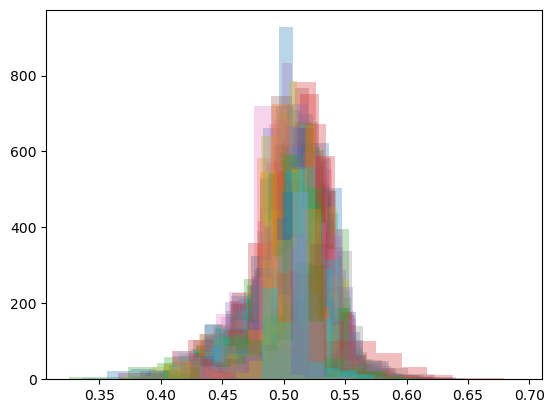

In [12]:
for t in range(n_trials):
    plt.hist(probas_good[t],alpha=0.3)
plt.show()

#### BAD MAF

In [13]:
n_trials = 1000
mean_bad = []
std_bad = []
probas_bad = []

for t in range(n_trials):   
    clf = local_flow_c2st(flow_values_train_bad, x_train)
    probas_bad.append(eval_local_flow_c2st(clf, x_0[0], dim=1))
    mean_bad.append(np.mean(probas_bad[t]))
    std_bad.append(np.std(probas_bad[t]))

torch.save(probas_bad, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/probas_bad.pkl')
torch.save(mean_bad, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/mean_bad.pkl')
torch.save(std_bad, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/std_bad.pkl')
    

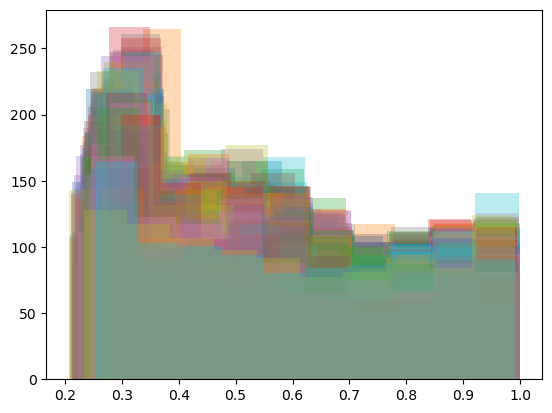

In [14]:
for t in range(n_trials):
    plt.hist(probas_bad[t],alpha=0.3)
plt.show()

#### PRIOR 


In [15]:
n_trials = 1000
mean_prior = []
std_prior = []
probas_prior = []

for t in range(n_trials):   
    clf = local_flow_c2st(theta_train, x_train)
    probas_prior.append(eval_local_flow_c2st(clf, x_0[0], dim=1))
    mean_prior.append(np.mean(probas_prior[t]))
    std_prior.append(np.std(probas_prior[t]))
torch.save(probas_prior, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/probas_prior.pkl')
torch.save(mean_prior, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/mean_prior.pkl')
torch.save(std_prior, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/std_prior.pkl')

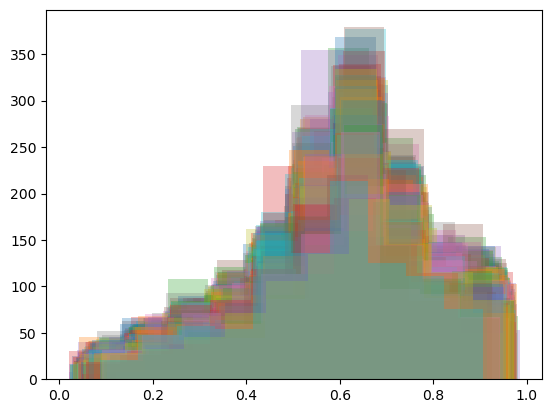

In [16]:
for t in range(n_trials):
    plt.hist(probas_prior[t],alpha=0.3)
plt.show()

#### NULL Hypothesis

In [17]:
n_trials = 1000
mean_null = []
std_null = []
probas_null = []

for t in range(n_trials):   
    clf = local_flow_c2st(norm_samples[:,None], x_train)
    probas_null.append(eval_local_flow_c2st(clf, x_0[0], dim=1))
    mean_null.append(np.mean(probas_null[t]))
    std_null.append(np.std(probas_null[t]))
torch.save(probas_null, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/probas_null.pkl')
torch.save(mean_null, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/mean_null.pkl')
torch.save(std_null, 'saved_experiments/Gaussian1d_localPIT/lct_c2st_results/std_null.pkl')

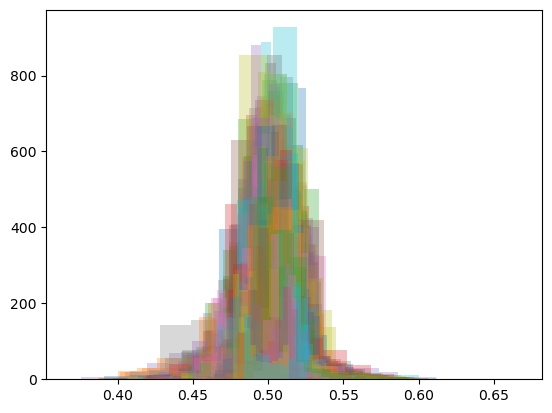

In [18]:
for t in range(n_trials):
    plt.hist(probas_null[t],alpha=0.3)
plt.show()

#### Confidence regions 

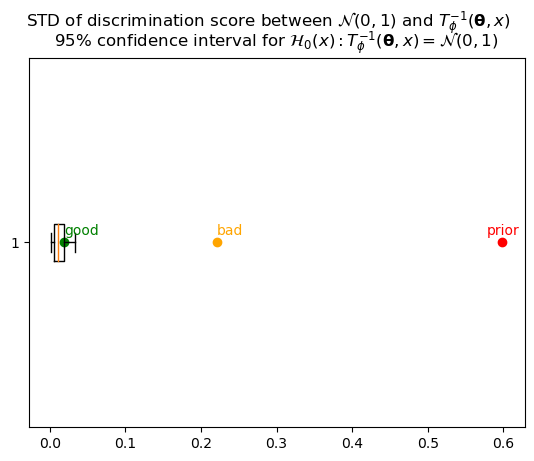

In [19]:
import matplotlib.cbook as cbook

data = std_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False,)
plt.text(np.mean(std_good), 1.02, 'good', color='green')
plt.scatter(np.mean(std_good), 1, color='green')
plt.text(np.mean(std_bad), 1.02, 'bad', color='orange')
plt.scatter(np.mean(std_bad), 1, color='orange')
plt.text(np.mean(mean_prior)-0.02, 1.02, 'prior', color='red')
plt.scatter(np.mean(mean_prior), 1, color='red')


# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x) : T_{\phi}^{-1}(\mathbf{\theta}, x) = \mathcal{N}(0,1)$')
plt.suptitle(r'STD of discrimination score between $\mathcal{N}(0,1)$ and $T_{\phi}^{-1}(\mathbf{\theta}, x)$')
plt.show()

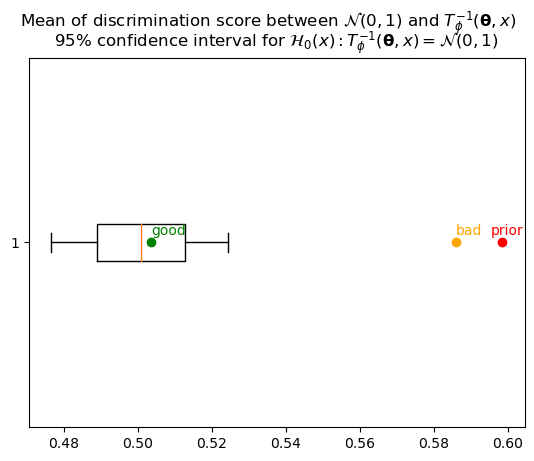

In [20]:
import matplotlib.cbook as cbook

data = mean_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False,)
plt.text(np.mean(mean_good), 1.02, 'good', color='green')
plt.scatter(np.mean(mean_good), 1, color='green')
plt.text(np.mean(mean_bad), 1.02, 'bad', color='orange')
plt.scatter(np.mean(mean_bad), 1, color='orange')
plt.text(np.mean(mean_prior)-0.003, 1.02, 'prior', color='red')
plt.scatter(np.mean(mean_prior), 1, color='red')


# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x) : T_{\phi}^{-1}(\mathbf{\theta}, x) = \mathcal{N}(0,1)$')
plt.suptitle(r'Mean of discrimination score between $\mathcal{N}(0,1)$ and $T_{\phi}^{-1}(\mathbf{\theta}, x)$')
plt.show()

#### Classifier choice


In [149]:
from sbi.utils.metrics import c2st

n_trials = 10
N = 1000
clfs = ['rf','mlp']
P = D.MultivariateNormal(loc=torch.zeros(1), covariance_matrix=torch.eye(1)).rsample((N,))
P_joint = torch.cat([P,x_train[:N]], dim=1)

In [150]:
#shifting means
means = np.linspace(0,4,11)
scale = 1
scores = {}

clf_method = []
mean_shift = []
score = []
for clf in clfs:
    scores[clf] = {}
    for m in means:
        scores[clf][m] = []
        for t in range(n_trials):
            Q = D.MultivariateNormal(loc=torch.FloatTensor([m]), covariance_matrix=torch.eye(1)*scale).rsample((N,))
            Q_joint = torch.cat([Q,x_train[:N]], axis=1)
            scores[clf][m].append(c2st(P_joint, Q_joint,classifier=clf).item())
            clf_method.append(clf)
            mean_shift.append(m)
            score.append(scores[clf][m][-1])

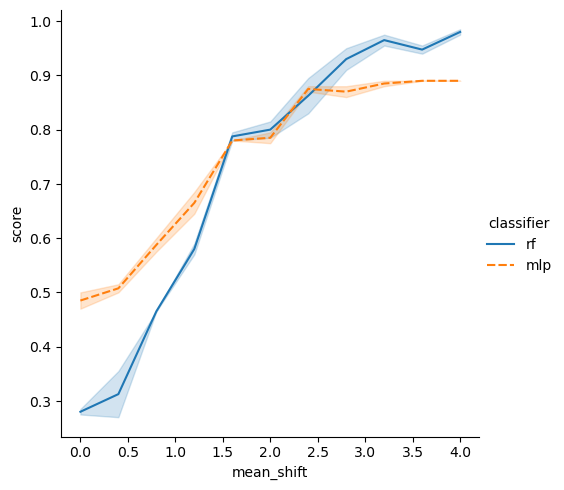

In [ ]:
df = pd.DataFrame({'mean_shift': mean_shift, 'score': score, 'classifier':clf_method,})
import seaborn as sns
sns.relplot(
    data=df, x="mean_shift", y="score",
    hue="classifier", style="classifier", kind="line",
)

In [ ]:
#shifting scales
mean = 0
scales = np.linspace(0,3,10)
scores = []
for m in means:
    Q = D.MultivariateNormal(loc=torch.FloatTensor([m]), covariance_matrix=torch.eye(1)*scale).rsample((N,))
    Q_joint = torch.cat([Q,x_train[:N]], axis=1)
    scores.append(c2st(P_joint, Q_joint,classifier='mlp'))

In [136]:
np.linspace(0,4,11)

array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ])